In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
data = pd.read_csv("../data/EURUSD_daily.csv", index_col='Date')

In [143]:
data.index = pd.to_datetime(data.index)
data.columns = ['close']

In [144]:
split_date = pd.Timestamp('01-01-2015')

In [145]:
data['log_ret'] = np.log(data.close) - np.log(data.close.shift(1))

In [146]:
mean = data.log_ret.mean()
std = data.log_ret.std()

In [147]:
data['normalized'] = 1/(1+np.exp(-(data.log_ret-mean)/std))

In [148]:
data.dropna(inplace=True)

In [149]:
data_n = data.drop('close', axis=1).drop('log_ret',axis=1)

In [150]:
train = data_n.loc[:split_date]
test = data_n.loc[split_date:]

In [151]:
for s in range (1,5):
    train['t-{}'.format(s)] = train['normalized'].shift(s)
    test ['t-{}'.format(s)] =  test['normalized'].shift(s)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [152]:
#inverse columns
train = train[train.columns[::-1]]
test = test[test.columns[::-1]]

In [153]:
train.head()

,t-4,t-3,t-2,t-1,normalized
Date,,,,,
2000-01-04,NaN,NaN,NaN,NaN,0.587550
2000-01-05,NaN,NaN,NaN,0.587550,0.568407
2000-01-06,NaN,NaN,0.587550,0.568407,0.429316
2000-01-07,NaN,0.587550,0.568407,0.429316,0.436854
2000-01-10,0.58755,0.568407,0.429316,0.436854,0.395031


In [154]:
x_train = train.dropna().drop('normalized', axis=1)
y_train = train.dropna()[['normalized']]

x_test = test.dropna().drop('normalized', axis=1)
y_test = test.dropna()[['normalized']]

In [155]:
x_train = x_train.values
y_train = y_train.values

x_test = x_test.values
y_test = y_test.values

In [156]:
x_train_t = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_t = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [157]:
x_train_t.shape

(3909, 4, 1)

In [158]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping

In [159]:
K.clear_session()

model = Sequential()

model.add(LSTM(100, input_shape = (x_train_t.shape[1], x_train_t.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

In [160]:
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

In [161]:
model.fit(x_train_t, y_train, epochs = 1000, batch_size=32, verbose = 1, callbacks=[early_stop])

Epoch 1/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 2/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 3/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 4/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 5/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 6/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 7/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 8/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 9/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 10/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 11/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 12/1000
3909/3909 [==============================] - 1s - loss: 0.0403     
Epoch 13/1000
3909/3909 [

In [162]:
y_pred = model.predict(x_test_t, batch_size=32)

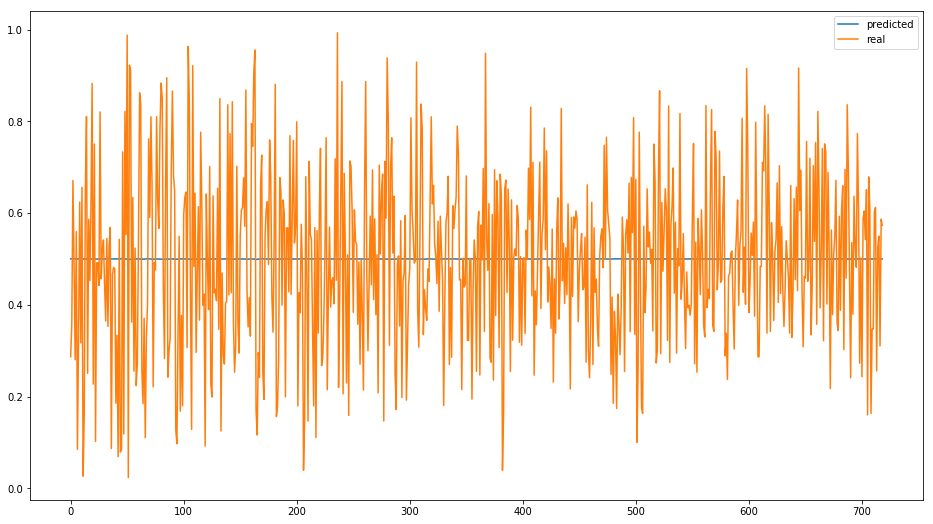

In [163]:
fig = plt.figure(figsize = (16,9))
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(['predicted', 'real'])

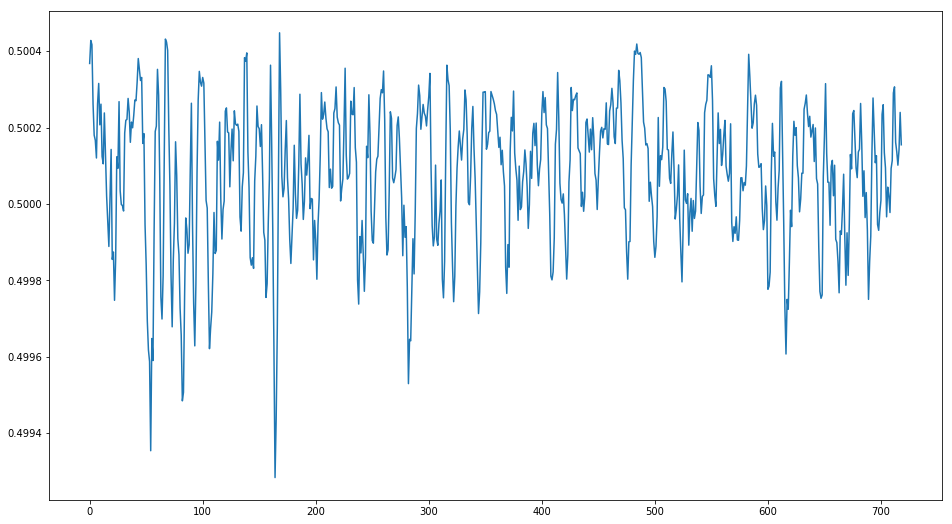

In [164]:
fig = plt.figure(figsize = (16,9))
plt.plot(y_pred)

In [165]:
evaluation_df = pd.DataFrame(y_pred, columns=['predicted'])

In [166]:
evaluation_df['real'] = y_test

In [167]:
evaluation_df['test_x_last'] = x_test[:,-1]

In [168]:
evaluation_df['predicted_move'] = (evaluation_df.predicted - evaluation_df.test_x_last) > 0
evaluation_df['real_move'] = (evaluation_df.real - evaluation_df.test_x_last) > 0

In [169]:
evaluation_df['guess_correct'] = evaluation_df.predicted_move == evaluation_df.real_move

In [170]:
evaluation_df[evaluation_df['guess_correct']==False].count() / evaluation_df.count()

predicted         0.230876
real              0.230876
test_x_last       0.230876
predicted_move    0.230876
real_move         0.230876
guess_correct     0.230876
dtype: float64

In [171]:
evaluation_df[evaluation_df['guess_correct']==True].count() / evaluation_df.count()

predicted         0.769124
real              0.769124
test_x_last       0.769124
predicted_move    0.769124
real_move         0.769124
guess_correct     0.769124
dtype: float64

In [172]:
def R_squared (y_pred, y_real):
    ss_res = np.sum((y_real-y_pred)**2)
    ss_tot = np.sum((y_real-np.mean(y_real))**2)
    return 1 - (ss_res/ss_tot)

In [173]:
r_sq = R_squared(evaluation_df['predicted'], evaluation_df['real'])

In [174]:
r_sq

-0.00015344434500841331